# Tennis - Encoder Decoder  | Pretrained

In [108]:
import sys
sys.path.append('..')
from time import time
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython.display import Image, HTML
import pandas as pd
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Collect an ensemble of box data

In [2]:
def convert_to_float(collection):
    return [x/255 for x in collection]

In [3]:
def get_processed_collection(folder):
    collection = get_collection(folder)
    collection = convert_to_float(collection)
    collection = center_collections(collection)
    return collection

In [4]:
train_collection = get_processed_collection("../data/tennis/train")
total_train = sum([x.shape[0] for x in train_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(train_collection), total_train))

{'images:': 'Tennis-train-1', 'dim': (200, 160, 256, 3)}
{'images:': 'Tennis-train-2', 'dim': (186, 160, 256, 3)}

After Augmentation: img_collections has 2 collections, 932 images in total


In [5]:
test_collection = get_processed_collection("../data/tennis/test")
total_test = sum([x.shape[0] for x in test_collection])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(test_collection), total_test))

{'images:': 'Tennis-test-1', 'dim': (80, 160, 256, 3)}

After Augmentation: img_collections has 1 collections, 466 images in total


## Sample from Collection

In [6]:
def sample(collection, batch_size = 8, gap = 1):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img, mid_imgs -  [batch size, 32, 32]
    """
    assert gap%2==1, "Gap must be odd !"      
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(num_per_collection[i] - gap - 1), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    mid_imgs = np.concatenate([collection[i][mid_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    mid_imgs = mid_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    return before_imgs, after_imgs, mid_imgs


def sample_train(batch_size = 8, gap = 1): return sample(train_collection, batch_size, gap = gap)

def sample_test(batch_size = 8, gap = 1):  return sample(test_collection, batch_size, gap)

def sample_marple(batch_size = 8, gap = 1):  return sample(marple_collection, batch_size, gap)

## Take a look at Training data

Range of Image Piece Value: [-0.9137254901960784, 1.0]
Before: (4, 160, 256, 3)
After:  (4, 160, 256, 3)
Mid:    (4, 160, 256, 3)


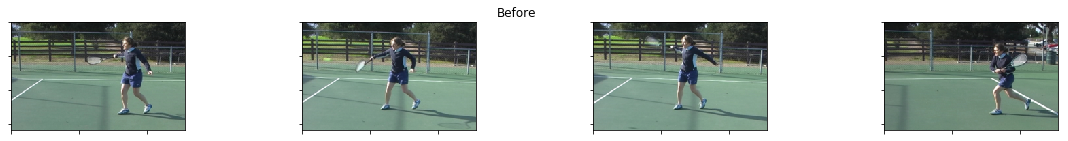

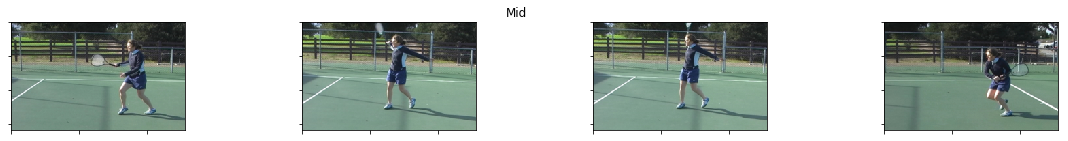

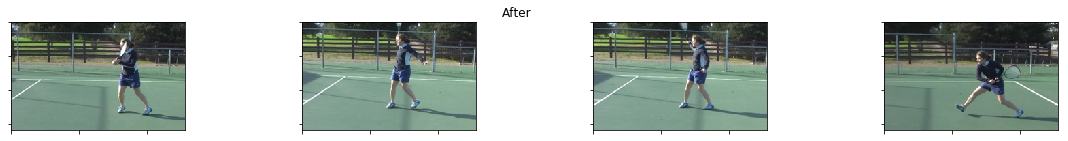

In [7]:
def show_sample_train(batch_size, gap):
    before, after, mid = sample_train(batch_size=batch_size, gap=gap)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(mid), np.max(mid)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    print("Mid:    {}".format(mid.shape))
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(mid, size, "Mid")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 4, gap = 9)

# Param

In [9]:
pretrained_model_folder = "../trained_model/tennis/iter-6000/"
pretrained_model_path = pretrained_model_folder + "-6000.meta"
batch_size = 6

In [10]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    return gen_batch

## Load Model

In [11]:
sess = tf.Session()
saver = tf.train.import_meta_graph(pretrained_model_path)
saver.restore(sess, tf.train.latest_checkpoint(pretrained_model_folder))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ../trained_model/tennis/iter-6000/-6000


### get place holders

In [12]:
batch_mid = graph.get_tensor_by_name("batch_mid:0")
batch_before = graph.get_tensor_by_name("batch_before:0")
batch_after = graph.get_tensor_by_name("batch_after:0")
is_training = graph.get_tensor_by_name("is_training:0")

In [13]:
G_batch = tf.get_collection("G_batch")[0]
loss = tf.get_collection("loss")[0]

### Report Loss = loss_computed * 255 / batch_size

In [14]:
def report_loss(name, batch_size, num_run = 100, gap = 3):
    losses = []
    for _ in range(num_run):
        if name == "train": before, after, mid = sample_train(batch_size, gap)
        elif name == "val": before, after, mid = sample_dev(batch_size, gap)
        else:                before, after, mid = sample_test(batch_size, gap) 
        loss_val = sess.run(loss, \
                        feed_dict = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False})
        losses.append(loss_val)
    return scale_loss(np.mean(losses) / batch_size, 2)

In [15]:
def show_generations(name, num = 6, gap = 3):
    if name == "train":   before, after, mid = sample_train(num, gap)
    elif name == "test":  before, after, mid = sample_test(num, gap) 
    else:                 before, after, mid = sample_marple(num, gap) 
    
    gen_batch = get_generattion(before, after, mid)
    size = (20, 2)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    plot_images(mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

## - Evaluate on Training Data

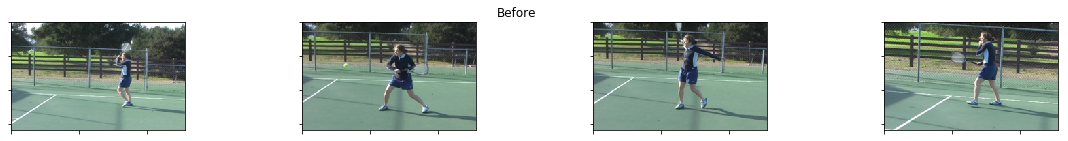

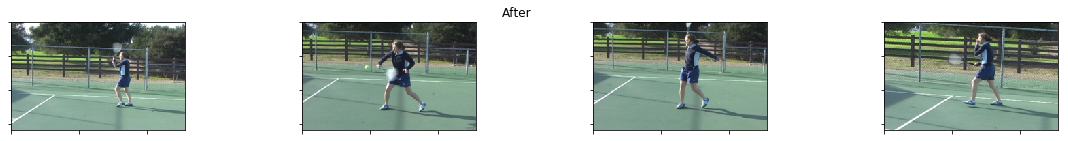

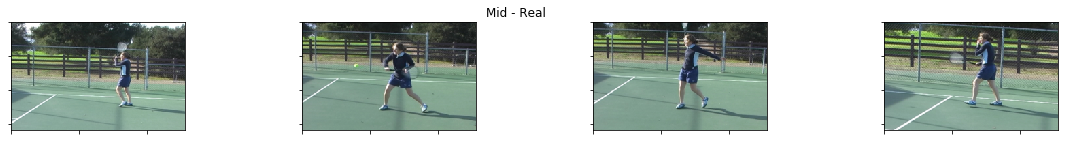

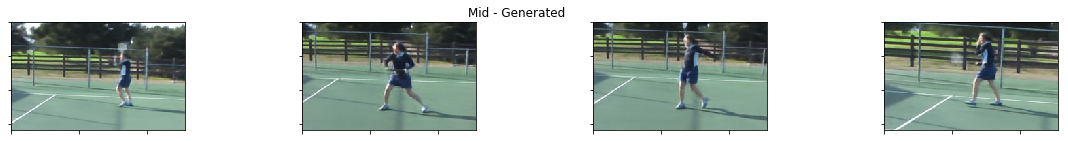

Training Loss = 1215.5997228622437


In [16]:
def eval_train(num_show = 8, gap = 3):
    show_generations("train", num_show, gap)
    loss = report_loss("train", batch_size = 6, num_run = 10, gap = gap)
    print("Training Loss = {}".format(loss))
    return loss

train_loss = eval_train(num_show = 4, gap = 1)

## - Evaluate on Test Data

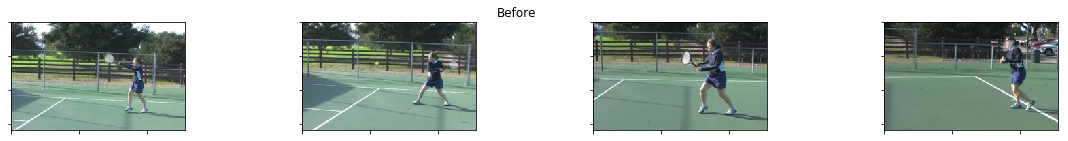

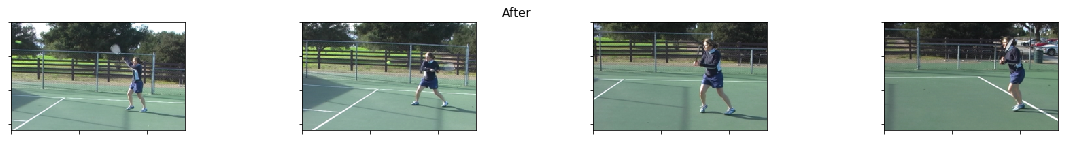

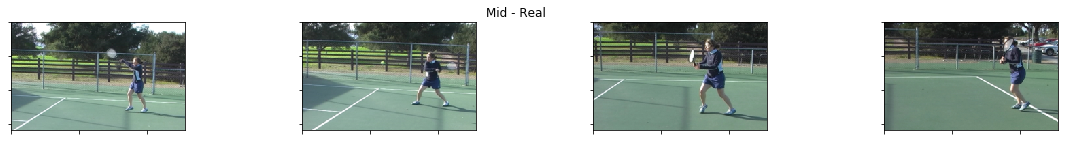

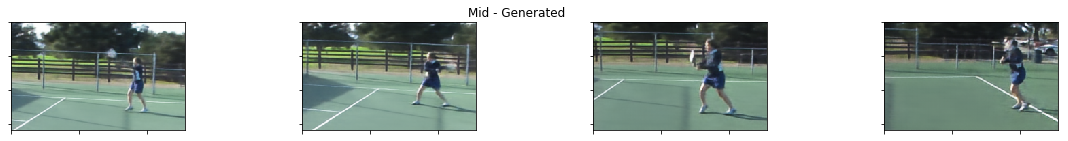

Test Loss = 1238.4075784683228


In [19]:
def eval_test(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
    show_generations("test", num_show, gap)
    loss = report_loss("test", batch_size = 6, num_run = 10, gap = gap)
    print("Test Loss = {}".format(loss))
    return loss

test_loss = eval_test(num_show = 4, gap=1, batch_size = 8, num_test=10)

## How much overfitting?

In [21]:
print("(Test Loss - Train Loss)/Train Loss = {}".format((test_loss-train_loss)/train_loss))

(Test Loss - Train Loss)/Train Loss = 0.0010165093402537437


# Test on a different dataset

In [22]:
# def eval_test_diff(num_show = 6, gap = 3, num_test = 100, batch_size = batch_size):
#     show_generations("marple", num_show, gap)
#     loss = report_loss("marple test", batch_size = 6, num_run = 10, gap = gap)
#     print("Test Loss = {}".format(loss))
#     return loss

# marple_loss = eval_test_diff(num_show = 4, gap=5, batch_size = 8, num_test=10)

# Generate Flow 

In [20]:
def display_gifs(gifs, names, width=100):
    header = ''.join('<th style="text-align: left">{}</th>'.format(name) for name in names)
    header = '<tr>' + header + '</tr>'
    body = ''.join('<td><img src="{}"</td>'.format(gif) for gif in gifs)
    body = '<tr>' + body + '</tr>'
    html = '<table width=100%>' + header + body + '</table>'
    return display.HTML(html)

In [133]:
def generate_gif(name, frames, out_folder, duration = 1):
    """
    generate a gif in out_folder by name, and return the final path to the gif
    """
    output = os.path.join(out_folder, "{}.gif".format(name))
    gif.compile_frames_to_gif(frames, output, duration=duration)
    return output
    
def generate_comp_gif(num_span = 4, gap = 1, duration = 1, add_border = True):
    """
    generate compare gif
    """
    frames = test_collection[np.random.choice(range(len(test_collection)))]
    num_seq_frames = (num_span-1)*(gap+1) + 1
    sequence = sample_sequence(frames, num_seq_frames)
    before_ind = np.array([(gap+1)*i for i in range(num_span)])
    mid_ind = before_ind + (gap+1)//2
    after_ind = before_ind + gap + 1
    raw_seq_ind = before_ind + [after_ind[-1]]
    
    batch_before, batch_mid, batch_after = frames[before_ind], frames[mid_ind], frames[after_ind]
    
    gen_batch = get_generattion(batch_before, batch_after, batch_mid)
    
    batch_before = depreprocess_to_uint8(batch_before)
    batch_mid = depreprocess_to_uint8(batch_mid)
    batch_after = depreprocess_to_uint8(batch_after)
    gen_batch = depreprocess_to_uint8(gen_batch)
    baseline_batch = avg_imges(batch_before, batch_after)
    
    if add_border: 
        gen_batch = add_border_to_imgs(gen_batch, 4, "red")
        baseline_batch = add_border_to_imgs(baseline_batch, 4, "red")
        
    raw_frames = list(batch_before) + [batch_after[-1]]
    baseline_frames = merge(raw_frames, baseline_batch)
    our_frames = merge(raw_frames, gen_batch)
    gd_frames = merge(raw_frames, batch_mid)
    
    time_stamp = time()
    raw_gif = generate_gif("Raw-{}".format(time_stamp), raw_frames, out_folder, duration = 2*duration)
    baseline_gif = generate_gif("LinerInterpolation-{}".format(time_stamp), baseline_frames, out_folder, duration = duration)
    our_gif = generate_gif("Ours-{}".format(time_stamp), our_frames, out_folder, duration = duration)
    gd_gif = generate_gif("GroundTruth-{}".format(time_stamp), gd_frames, out_folder, duration = duration)
#     print("All GIF Generated!")
    return raw_gif, baseline_gif, our_gif, gd_gif


In [135]:
out_folder = "../output/gif/tennis/"
raw_gif, baseline_gif, our_gif, gd_gif = generate_comp_gif(num_span = 20, duration=0.6)
display_gifs([raw_gif, baseline_gif, our_gif, gd_gif], ["Raw Flow", "Linear Interpolation Flow", "Ours", "Ground Truth"], width = 200)

Raw Flow,Linear Interpolation Flow,Ours,Ground Truth
"<img src=""../output/gif/tennis/Raw-1496557929.18039.gif""","<img src=""../output/gif/tennis/LinerInterpolation-1496557929.18039.gif""","<img src=""../output/gif/tennis/Ours-1496557929.18039.gif""","<img src=""../output/gif/tennis/GroundTruth-1496557929.18039.gif"""


## Remove Generated GIF

In [127]:
rm -rf ../output/gif/tennis/*